In [11]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pandas as pd
import sys

In [12]:
kB = 1.38e-23 # V / K
h = 6.626e-34 # J * s
hbar = 1.054e-34 # J * s

e = 1.602e-19 # C
me = 9.11e-31 # kg
Na = 6.02e23 # /mol

In [13]:
def read_STD2(fpath : str):
    df = pd.read_csv(fpath)
    return df


In [14]:
def reduced_df_by_sample(full_df, composition: str):
    comp_df = full_df.loc[full_df['composition'] == composition]
    return comp_df


In [15]:
def add_weighted_mobility(comp_df):
    S = comp_df['Seebeck coefficient'] #units of V/K
    rho = comp_df['Electrical resistivity'] #units of Ohm*m
    sigma = comp_df['Electrical conductivity']
    T = comp_df['Temperature'] #units of K
    rat = kB / e
    aS = np.abs(S)
    muW = 331 * (1e-5 / rho) * (T / 300)**(-3 / 2) * (np.exp(aS/rat - 2)\
                 /(1 + np.exp(-5 * (aS/rat -1))) + 3 * aS / (pi**2 * rat)\
                 /(1 + np.exp(5 * (aS/rat -1)))) 
    comp_df['Weighted mobility'] = muW
    return comp_df


In [16]:
def add_effective_mass(comp_df):
    S = comp_df['Seebeck coefficient'] #units of V/K
    rho = comp_df['Electrical resistivity'] #units of Ohm*m
    sigma = comp_df['Electrical conductivity']
    T = comp_df['Temperature'] #units of K
    nH = comp_df['Carrier concentration']
    rat = kB / e
    aS = np.abs(S)
    muS = (h**2/(2*kB*T))*(3*nH/16*pi**.5)**(2/3)* ((np.exp(aS/rat - 2)-0.17)**(2/3)\
                 /(1 + np.exp(-5 * (aS/rat -1))) + (3/pi**2)*(2/pi**0.5)**(2/3) * aS / (pi**2 * rat)\
                 /(1 + np.exp(5 * (aS/rat -1)))) 
    comp_df['Seebeck Effective Mass'] = muS/me
    return comp_df

In [17]:
def split_sampleid(comp_df):
    sid = comp_df['sampleid'].to_numpy()
    unique_sampleid, sampleid_counts = np.unique(sid, return_counts=True)
    data = {}
    for sampleid in unique_sampleid:
        data[str(int(sampleid))] = comp_df.loc[comp_df['sampleid'] == sampleid]
    #print(data)
    return data
'''
new_data = split_sampleid(comp_df)
#sample calc
x = new_data['31213']['Temperature'].to_numpy()
#issue: composition is undefined 
print(x)
'''

"\nnew_data = split_sampleid(comp_df)\n#sample calc\nx = new_data['31213']['Temperature'].to_numpy()\n#issue: composition is undefined \nprint(x)\n"

In [18]:
#def samplename(comp_df):
    

In [19]:
def merge_Hallmobility_columns(comp_df):
    for j in comp_df.index:
        if not pd.isna(comp_df['Hall movility'][j]):
            comp_df['Carrier mobility'][j] = comp_df['Hall movility'][j]
    comp_df.pop('Hall movility')
    return comp_df



In [20]:
def plot_mobility(comp_df):
    #Hall mobility plot
    plt.figure()
    plt.scatter(comp_df['Temperature'], comp_df['Carrier mobility'] * 1e4, color ='red', marker = '>')
    plt.ylabel(r'$\mu_H$ (cm$^2$/V/s)')
    plt.xlabel('Temperature (K)')
   
    #line style, while loop, xkcd 
    
    #Weighted mobility plot
    plt.figure()
    plt.scatter(comp_df['Temperature'], comp_df['Weighted mobility'])
    plt.ylabel(r'$\mu_W$ (cm$^2$/V/s)')
    plt.xlabel('Temperature (K)')
    
    #Combined Plot
   
    x = comp_df['Temperature']
    y1 = comp_df['Carrier mobility'] * 1e4
    y2 = comp_df['Weighted mobility']
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(x, y1, 'blue', marker = 'o', linewidth=0.5, markersize=2)
    ax2.plot(x, y2, 'green', marker = 'x', linewidth = 0.3, markersize=2)

    ax1.set_xlabel('Temperature (Kelvin)')
    ax1.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'blue')
    ax2.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'green')
    plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
    plt.show()
   
    # Seebeck coeff versus cond 
    
    y3 = comp_df['Seebeck coefficient'] * 1e4 #units of V/K
    x2 = comp_df['Electrical conductivity'] #units of Ohm*m
    plt.figure()
    plt.scatter(x2, y3, marker = '*', color = 'indigo')
    plt.ylabel('Seebeck Coefficient, S (V/K)')
    plt.xlabel('Electrical Conductivity, \u03C3 (S/m)')
    
    #add pisarenko plot (S versus carrier conc nh)
    
    y4 = comp_df['Seebeck coefficient'] * 1e4 #units of V/K
    x3 = comp_df['Carrier concentration'] #units of Ohm*m
    plt.figure()
    plt.scatter(x3, y4, marker = '>', color = 'grey')
    plt.ylabel('Seebeck Coefficient, S (V/K)')
    plt.xlabel('Carrier concentration, $n_H$ (1/cm$^3$)')
    plt.title('Pisarenko Plot of p-Type Zintl Phase Ca₉Zn₍₄₊ₓ₎Sb₉')
    
  

undefined


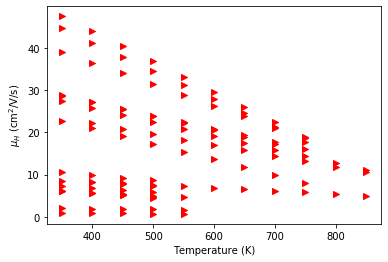

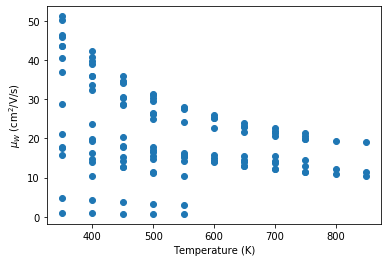

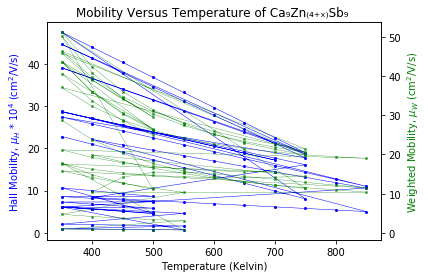

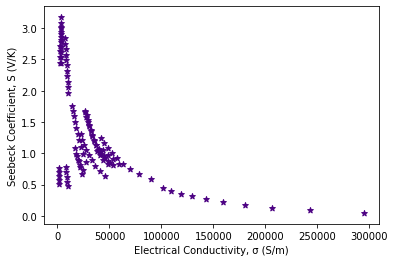

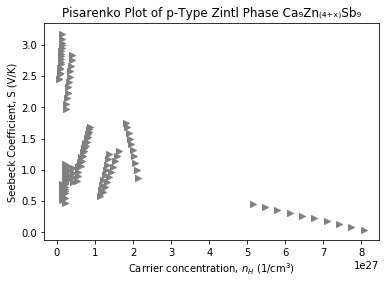

In [23]:
if __name__ == '__main__':
    #Provide path to the .csv file exported from sTarryData2
    full_df = read_STD2('../csvfiles/Ca_ptype.csv')
    #Dropping all rows that don't contain mobility data in either "Carrier mobility" or "Hall movility"
    if 'Hall movility' not in full_df.columns:
        full_df['Hall movility'] = np.nan #ad column of empty values
    elif 'Carrier mobility' not in full_df.columns:
        full_df['Carrier mobility'] = np.nan #ad column of empty values
    hall_df = full_df.dropna(how = 'all', subset = ['Hall movility','Carrier mobility'])
    #Drop any rows that don't contain both Seebeck and Conductivity data too
    hall_df = hall_df.dropna(how = 'any', subset = ['Seebeck coefficient', 'Electrical resistivity'])
    #Merge Hall mobility data from different columns
    hall_df = merge_Hallmobility_columns(hall_df)
    composition = hall_df['composition'][hall_df.index[0]] #Choosing first composition with Hall mobility data
    #Print composition
    print(composition)
    #Get dataframe for just the composition of interest
    comp_df = reduced_df_by_sample(hall_df, composition)
    #Add weighted mobility data
    comp_df = add_weighted_mobility(comp_df)
    #Plots of weighted mobility and Hall mobility
    plot_mobility(comp_df)
    # call effective mass, in terms of mass by e- (divide)
    comp_df = add_effective_mass(comp_df)
    mean = comp_df['Seebeck Effective Mass'].mean()
    #print(mean)
    stdev = comp_df['Seebeck Effective Mass'].std()
    #print(stdev)
    #print(comp_df['Seebeck Effective Mass'])
    new_data = split_sampleid(comp_df)
 
  


[350 400 450 500 550 600 650 700 750]


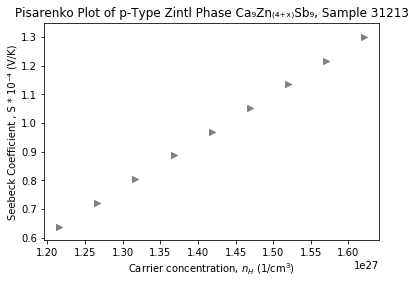

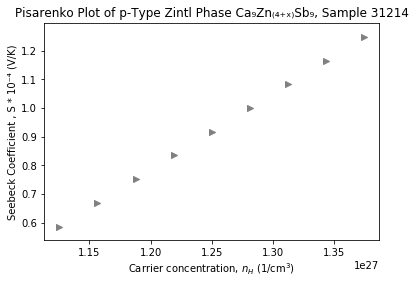

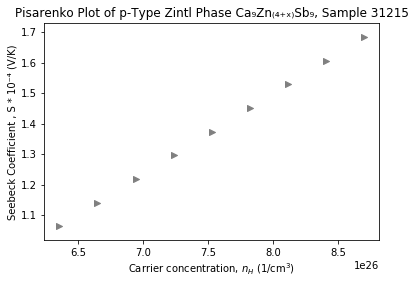

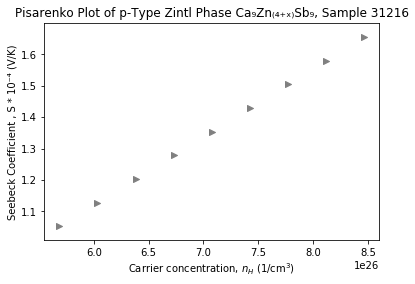

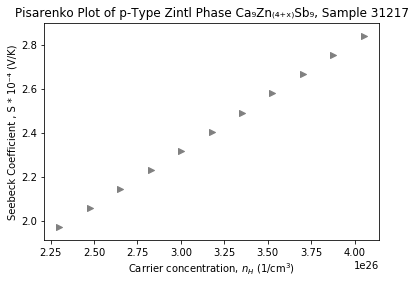

In [24]:
# Pisarenko Plots 
# S dec w/ nH dec cuz metal becomes more metallic 
# carr conc inc w/ T, S dec w/ T 
list = ['31213', '31214', '31215', '31216', '31217']
composition = new_data['31213']['Temperature'].to_numpy()
print(composition)
for i in list: 
    x10 = new_data[i]['Carrier concentration'].to_numpy() #units of V/K
    y10 = new_data[i]['Seebeck coefficient'].to_numpy() * 1e4 #units of Ohm*m
    plt.figure()
    plt.scatter(x10, y10, marker = '>', color = 'grey')
    plt.ylabel('Seebeck Coefficient , S * 10⁻⁴ (V/K)')
    plt.xlabel('Carrier concentration, $n_H$ (1/cm$^3$)')
    plt.title('Pisarenko Plot of p-Type Zintl Phase Ca₉Zn₍₄₊ₓ₎Sb₉, Sample {}'.format(i))
   
# grab interploated data
# Ca Zn Sb compare 
# upwards slope weird - nh inc, S dec ()
# mult S in mV/K, mult by 1e6

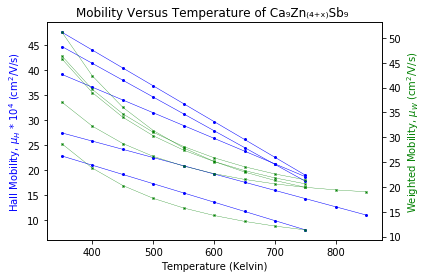

In [25]:
#old
# Weighted Mobility Plots (double axes)

#colors 

items = ['31213', '31214', '31215', '31216', '31217']
darkcol = ['firebrick', 'orange', 'green', 'navy', 'purple' ]
lightcol = ['red', 'yellow', 'lime', 'cyan', 'magenta']
fig, ax4 = plt.subplots()
ax5 = ax4.twinx()

for i in items: 
    x = new_data[i]['Temperature'].to_numpy()
    a = new_data[i]['Carrier mobility'].to_numpy() *1e4
    b = new_data[i]['Weighted mobility'].to_numpy() 

    ax4.plot(x, a, 'blue', marker = 'o', linewidth=0.5, markersize=2)
    ax5.plot(x, b, 'green', marker = 'x', linewidth = 0.3, markersize=2)

    ax4.set_xlabel('Temperature (Kelvin)')
    ax4.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'blue')
    ax5.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'green')
    plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
plt.show()
    
# hall are warm colors
# weighted are cold 
# send plots for comments
# check trends, read paper (linearity)

In [ ]:
# Weighted Mobility Plots (double axes)

#colors 
nums = [ 1, 2, 3, 4, 5] 
items = ['31213', '31214', '31215', '31216', '31217']
darkcol = ['firebrick', 'sienna', 'green', 'darkblue', 'darkorchid' ]
lightcol = ['salmon', 'tan', 'greenyellow', 'lightskyblue', 'thistle']
fig, ax4 = plt.subplots()
ax5 = ax4.twinx()

for i in nums: 
    x = new_data[items[i-5]]['Temperature'].to_numpy()
    a = new_data[items[i-5]]['Carrier mobility'].to_numpy() *1e4
    b = new_data[items[i-5]]['Weighted mobility'].to_numpy() 

    ax4.plot(x, a, darkcol[i-5], marker = 'o', linewidth = 2, markersize = 7.5)
    ax5.plot(x, b, darkcol[i-5], marker = '*', linewidth = 1, markersize = 7.5)

    ax4.set_xlabel('Temperature (Kelvin)')
    ax4.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'black')
    ax5.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'black')
    plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
plt.show()
    
# hall are warm colors
# weighted are cold 
# send plots for comments
# check trends, read paper (linearity)
# hall linear
#weighted curved 

[ 1.90974188  2.53255512  3.32257964  4.23574511  5.1955691   6.12338921
  6.96596773  7.71095865  8.36829649  1.41603557  1.87294951  2.47918858
  3.21825112  4.03742468  4.86439349  5.63791838  6.32358605  6.9199048
  1.90974188  2.53255512  3.32257964  4.23574511  5.1955691   6.12338921
  6.96596773  7.71095865  8.36829649  6.16350607  6.594631    6.96040647
  7.27488156  7.55357844  7.81404161  8.06920578  8.32939652  8.59928882
  1.41603557  1.87294951  2.47918858  3.21825112  4.03742468  4.86439349
  5.63791838  6.32358605  6.9199048   5.58069759  6.02380886  6.41188705
  6.75396867  7.06142179  7.35026318  7.63024315  7.91138014  8.20087569
  6.16350607  6.594631    6.96040647  7.27488156  7.55357844  7.81404161
  8.06920578  8.32939652  8.59928882  9.90857369  9.83586558  9.87389168
  9.99644873 10.18792317 10.43689176 10.73882823 11.08894019 11.48428247
 11.92272622 12.40567018  5.58069759  6.02380886  6.41188705  6.75396867
  7.06142179  7.35026318  7.63024315  7.91138014  8.

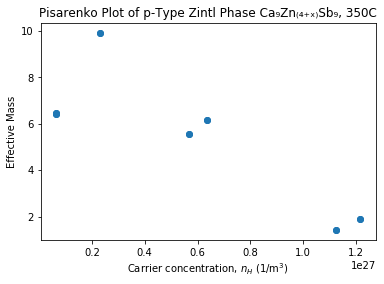

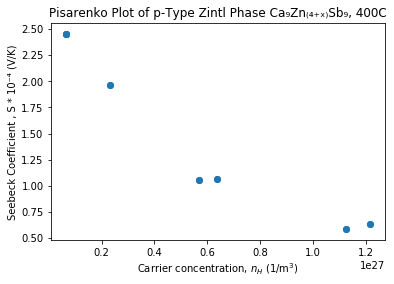

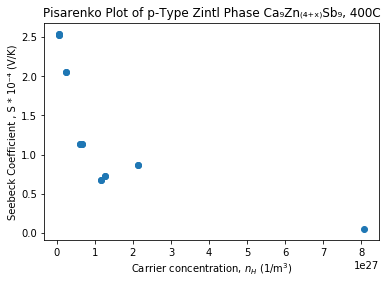

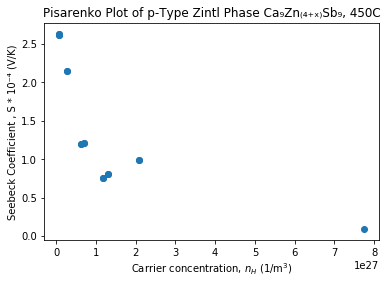

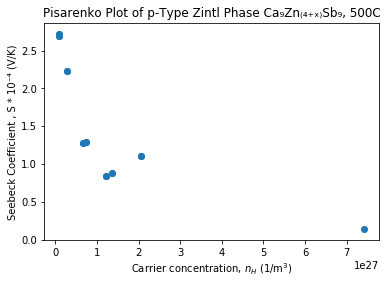

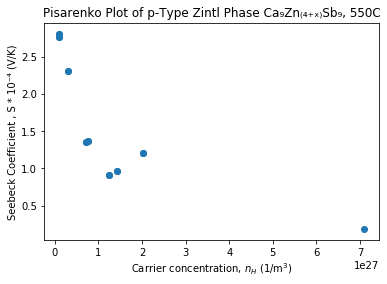

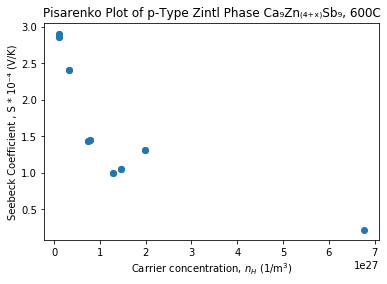

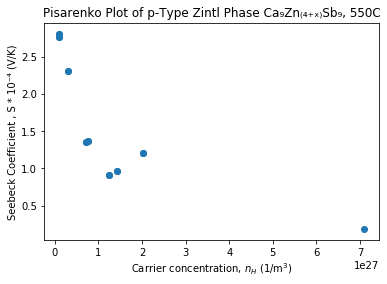

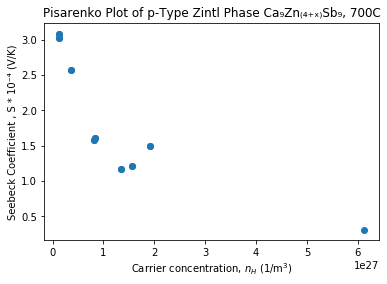

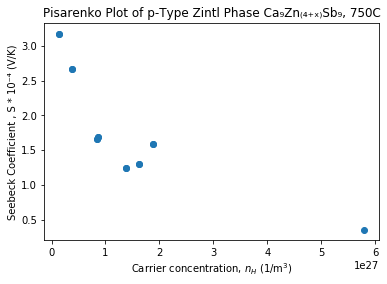

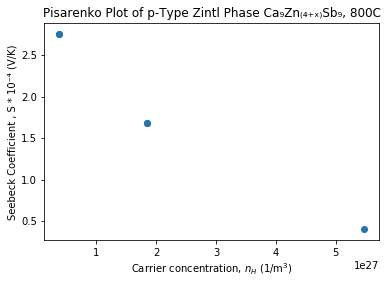

In [26]:
# Revised Pisarenko Plots
x = np.arange(31213, 31222)
i = 0
arr = []
arr1 = np.array([])
z = 0
arr2 = np.array([])
arr3 = np.array([])
arr4 = np.array([])
out1 = np.array([])
out2 = np.array([])
out3 = np.array([])
out4 = np.array([])

# while loop to get 3 separate arrays 
while i < len(x):
    # temperature array
    out1a = out1
    out1 = new_data[str(x[i])]['Temperature'].to_numpy()
    arr1 = np.append(arr1,out1)
    arr1 = np.append(arr1,out1a)
    # carrier conc array
    out2a = out2
    out2 = new_data[str(x[i])]['Carrier concentration'].to_numpy()
    arr2 = np.append(arr2,out2)
    arr2 = np.append(arr2,out2a)
    # S coeff array
    out3a = out3
    out3 = new_data[str(x[i])]['Seebeck coefficient'].to_numpy()
    arr3 = np.append(arr3,out3)
    arr3 = np.append(arr3,out3a)
     # S eff mass array
    out4a = out4
    out4 = new_data[str(x[i])]['Seebeck Effective Mass'].to_numpy()
    arr4 = np.append(arr4,out4)
    arr4 = np.append(arr4,out4a)
    i = i + 1

print(arr4)

z = 0

# prep the x and y axes
arr350x = np.array([])
arr350y = np.array([])
arr350ye = np.array([])

arr400x = np.array([])
arr400y = np.array([])
arr400ye = np.array([])

arr450x = np.array([])
arr450y = np.array([])
arr450ye = np.array([])

arr500x = np.array([])
arr500y = np.array([])
arr500ye = np.array([])

arr550x = np.array([])
arr550y = np.array([])
arr550ye = np.array([])

arr600x = np.array([])
arr600y = np.array([])
arr600ye = np.array([])

arr650x = np.array([])
arr650y = np.array([])
arr650ye = np.array([])

arr700x = np.array([])
arr700y = np.array([])
arr700ye = np.array([])

arr750x = np.array([])
arr750y = np.array([])
arr750ye = np.array([])

arr800x = np.array([])
arr800y = np.array([])
arr800ye = np.array([])

arr850x = np.array([])
arr850y = np.array([])
arr850ye = np.array([])

#extract the values for each tempearture by searching for each temperature (only works for interpolated)
j = 0
while j < len(arr1):
    if arr1[j] == 350:
        arr350x = np.append(arr350x,arr2[j])
        arr350y = np.append(arr350y,arr3[j])
        arr350ye = np.append(arr350ye,arr4[j])
    if arr1[j] == 400:
        arr400x = np.append(arr400x,arr2[j])
        arr400y = np.append(arr400y,arr3[j])
        arr400ye = np.append(arr400ye,arr4[j])
    if arr1[j] == 450:
        arr450x = np.append(arr450x,arr2[j])
        arr450y = np.append(arr450y,arr3[j])
        arr450ye = np.append(arr450ye,arr4[j])
    if arr1[j] == 500:
        arr500x = np.append(arr500x,arr2[j])
        arr500y = np.append(arr500y,arr3[j])
        arr500ye = np.append(arr500ye,arr4[j])
    if arr1[j] == 550:
        arr550x = np.append(arr550x,arr2[j])
        arr550y = np.append(arr550y,arr3[j])
        arr550ye = np.append(arr550ye,arr4[j])
    if arr1[j] == 600:
        arr600x = np.append(arr600x,arr2[j])
        arr600y = np.append(arr600y,arr3[j])
        arr600ye = np.append(arr600ye,arr4[j])
    if arr1[j] == 650:
        arr650x = np.append(arr650x,arr2[j])
        arr650y = np.append(arr650y,arr3[j])
        arr650ye = np.append(arr650ye,arr4[j])
    if arr1[j] == 700:
        arr700x = np.append(arr700x,arr2[j])
        arr700y = np.append(arr700y,arr3[j])
        arr700ye = np.append(arr700ye,arr4[j])
    if arr1[j] == 750:
        arr750x = np.append(arr750x,arr2[j])
        arr750y = np.append(arr750y,arr3[j])
        arr750ye = np.append(arr750ye,arr4[j])
    if arr1[j] == 800:
        arr800x = np.append(arr800x,arr2[j])
        arr800y = np.append(arr800y,arr3[j])
        arr800ye = np.append(arr800ye,arr4[j])
    j = j + 1

#not it 

print (arr350x)
print (arr350y)
print (arr350ye)


# 350 degrees
x350 = arr350x
y350 = arr350ye[0:len(arr350x)]
plt.ylabel('Effective Mass')
plt.xlabel('Carrier concentration, $n_H$ (1/m$^3$)')
plt.title('Pisarenko Plot of p-Type Zintl Phase Ca₉Zn₍₄₊ₓ₎Sb₉, 350C'.format(i))
plt.scatter(x350, y350)
plt.show()


# 350 degrees
x350 = arr350x
y350 = arr350y * 10000
plt.ylabel('Seebeck Coefficient , S * 10⁻⁴ (V/K)')
plt.xlabel('Carrier concentration, $n_H$ (1/m$^3$)')
plt.title('Pisarenko Plot of p-Type Zintl Phase Ca₉Zn₍₄₊ₓ₎Sb₉, 400C'.format(i))
plt.scatter(x350, y350)
plt.show()

# 400 degrees
x400 = arr400x
y400 = arr400y * 10000
plt.ylabel('Seebeck Coefficient , S * 10⁻⁴ (V/K)')
plt.xlabel('Carrier concentration, $n_H$ (1/m$^3$)')
plt.title('Pisarenko Plot of p-Type Zintl Phase Ca₉Zn₍₄₊ₓ₎Sb₉, 400C'.format(i))
plt.scatter(x400, y400)
plt.show()

# 450 degrees
x450 = arr450x
y450 = arr450y * 10000
plt.ylabel('Seebeck Coefficient , S * 10⁻⁴ (V/K)')
plt.xlabel('Carrier concentration, $n_H$ (1/m$^3$)')
plt.title('Pisarenko Plot of p-Type Zintl Phase Ca₉Zn₍₄₊ₓ₎Sb₉, 450C'.format(i))
plt.scatter(x450, y450)
plt.show()

# 500 degrees
x500 = arr500x
y500 = arr500y * 10000
plt.ylabel('Seebeck Coefficient , S * 10⁻⁴ (V/K)')
plt.xlabel('Carrier concentration, $n_H$ (1/m$^3$)')
plt.title('Pisarenko Plot of p-Type Zintl Phase Ca₉Zn₍₄₊ₓ₎Sb₉, 500C'.format(i))
plt.scatter(x500, y500)
plt.show()

# 550 degrees
x550 = arr550x
y550 = arr550y * 10000
plt.ylabel('Seebeck Coefficient , S * 10⁻⁴ (V/K)')
plt.xlabel('Carrier concentration, $n_H$ (1/m$^3$)')
plt.title('Pisarenko Plot of p-Type Zintl Phase Ca₉Zn₍₄₊ₓ₎Sb₉, 550C'.format(i))
plt.scatter(x550, y550)
plt.show()

# 600 degrees
x600 = arr600x
y600 = arr600y * 10000
plt.ylabel('Seebeck Coefficient , S * 10⁻⁴ (V/K)')
plt.xlabel('Carrier concentration, $n_H$ (1/m$^3$)')
plt.title('Pisarenko Plot of p-Type Zintl Phase Ca₉Zn₍₄₊ₓ₎Sb₉, 600C'.format(i))
plt.scatter(x600, y600)
plt.show()

# 650 degrees
x550 = arr550x
y550 = arr550y * 10000
plt.ylabel('Seebeck Coefficient , S * 10⁻⁴ (V/K)')
plt.xlabel('Carrier concentration, $n_H$ (1/m$^3$)')
plt.title('Pisarenko Plot of p-Type Zintl Phase Ca₉Zn₍₄₊ₓ₎Sb₉, 550C'.format(i))
plt.scatter(x550, y550)
plt.show()

# 700 degrees
x700 = arr700x
y700 = arr700y * 10000
plt.ylabel('Seebeck Coefficient , S * 10⁻⁴ (V/K)')
plt.xlabel('Carrier concentration, $n_H$ (1/m$^3$)')
plt.title('Pisarenko Plot of p-Type Zintl Phase Ca₉Zn₍₄₊ₓ₎Sb₉, 700C'.format(i))
plt.scatter(x700, y700)
plt.show()

# 750 degrees
x750 = arr750x
y750 = arr750y * 10000
plt.ylabel('Seebeck Coefficient , S * 10⁻⁴ (V/K)')
plt.xlabel('Carrier concentration, $n_H$ (1/m$^3$)')
plt.title('Pisarenko Plot of p-Type Zintl Phase Ca₉Zn₍₄₊ₓ₎Sb₉, 750C'.format(i))
plt.scatter(x750, y750)
plt.show()

# 800 degrees
x800 = arr800x
y800 = arr800y * 10000
plt.ylabel('Seebeck Coefficient , S * 10⁻⁴ (V/K)')
plt.xlabel('Carrier concentration, $n_H$ (1/m$^3$)')
plt.title('Pisarenko Plot of p-Type Zintl Phase Ca₉Zn₍₄₊ₓ₎Sb₉, 800C'.format(i))
plt.scatter(x800, y800)
plt.show()

In [27]:
# effective mass calcs
x = np.arange(31213, 31222)
i = 0
arr = []
arr1 = np.array([])
z = 0
arr2 = np.array([])
arr3 = np.array([])

# while loop to get 3 separate arrays 
while i < len(x):
    # temperature array
    out1a = out1
    out1 = new_data[str(x[i])]['Temperature'].to_numpy()
    arr1 = np.append(arr1,out1)
    arr1 = np.append(arr1,out1a)
    # carrier conc array
    out2a = out2
    out2 = new_data[str(x[i])]['Carrier concentration'].to_numpy()
    arr2 = np.append(arr2,out2)
    arr2 = np.append(arr2,out2a)
    # S coeff array
    out3a = out3
    out3 = new_data[str(x[i])]['Seebeck Effective Mass'].to_numpy()
    arr3 = np.append(arr3,out3)
    arr3 = np.append(arr3,out3a)
    i = i + 1



In [ ]:
z = new_data['31213']['Seebeck Effective Mass'].to_numpy() #units of V/K
print(z)

# Effective Mass Plots

#colors 
nums = [ 1, 2, 3, 4, 5] 
items = ['31213', '31214', '31215', '31216', '31217']
darkcol = ['firebrick', 'sienna', 'green', 'darkblue', 'darkorchid' ]
lightcol = ['salmon', 'tan', 'greenyellow', 'lightskyblue', 'thistle']
fig, ax4 = plt.subplots()
ax5 = ax4.twinx()

for i in nums: 
    x = new_data[items[i-5]]['Temperature'].to_numpy()
    a = new_data[items[i-5]]['Carrier mobility'].to_numpy() *1e4
    b = new_data[items[i-5]]['Weighted mobility'].to_numpy() 

    ax4.plot(x, a, darkcol[i-5], marker = 'o', linewidth = 2, markersize = 7.5)
    ax5.plot(x, b, darkcol[i-5], marker = '*', linewidth = 1, markersize = 7.5)

    ax4.set_xlabel('Temperature (Kelvin)')
    ax4.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'black')
    ax5.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'black')
    plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
plt.show()
    
# hall are warm colors
# weighted are cold 
# send plots for comments
# check trends, read paper (linearity)
# hall linear
# weighted curved 

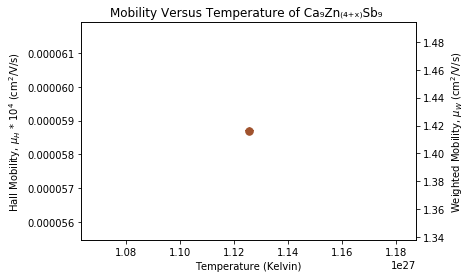

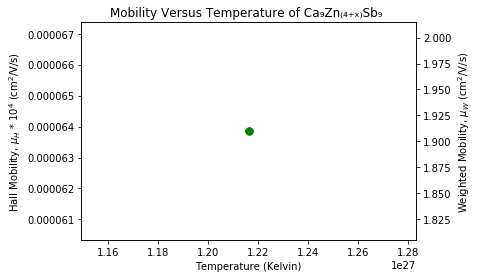

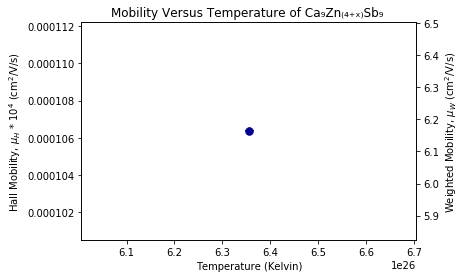

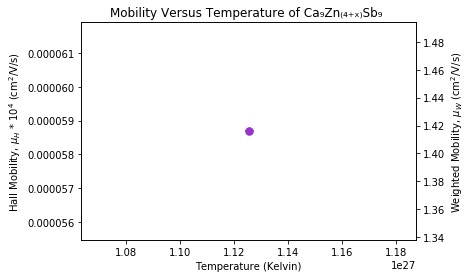

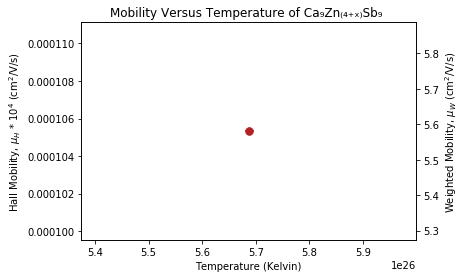

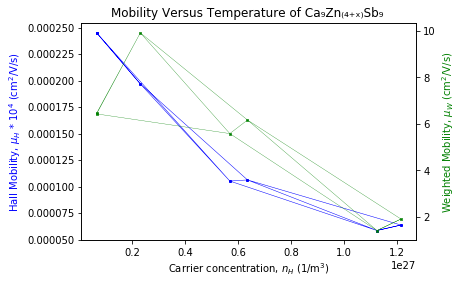

In [31]:
nums = [ 1, 2, 3, 4, 5] 
for i in nums: 
    
    items = ['31213', '31214', '31215', '31216', '31217']
    darkcol = ['firebrick', 'sienna', 'green', 'darkblue', 'darkorchid' ]
    lightcol = ['salmon', 'tan', 'greenyellow', 'lightskyblue', 'thistle']
    fig, ax4 = plt.subplots()
    ax5 = ax4.twinx()


    x = arr350x[i]
    a = arr350y[i]
    b = arr350ye[i] 

    ax4.plot(x, a, darkcol[i-5], marker = 'o', linewidth = 2, markersize = 7.5)
    ax5.plot(x, b, darkcol[i-5], marker = '*', linewidth = 1, markersize = 7.5)

    ax4.set_xlabel('Temperature (Kelvin)')
    ax4.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'black')
    ax5.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'black')
    plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
plt.show()
    
# fitted effective mass plot 350 

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()



ax1.plot(arr350x, arr350y, 'blue', marker = 'o', linewidth=0.5, markersize=2)
ax2.plot(arr350x, arr350ye[:len(arr350x)], 'green', marker = 'x', linewidth = 0.3, markersize=2)

ax1.set_xlabel('Carrier concentration, $n_H$ (1/m$^3$)')
ax1.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'blue')
ax2.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'green')
plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
plt.show()
       